### Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import joblib
import requests
import tarfile
import mailparser
import re
import base64
import hashlib
import mailbox
import tempfile # Importato per la gestione sicura dei file temporanei
from collections import Counter
from email import policy
from oletools.olevba import VBA_Parser
from scipy.stats import entropy as scipy_entropy
from tqdm import tqdm
from mailparser import parse_from_file
from concurrent.futures import ProcessPoolExecutor, as_completed

# Datasets

##### subject - body - label - source

In [ ]:
data_dir = '../dataset/seven_phishing_dataset'

datasets = [
    "Assassin.csv", # 7 features
    "CEAS-08.csv", # 7 features
    "Nigerian_Fraud.csv", # 7 features
    "Nazario.csv", # 7 features
    "Enron.csv", # solo 3 features
    "Ling.csv", # solo 3 features
]

all_data = []

for file in datasets:
    path = os.path.join(data_dir, file)
    df = pd.read_csv(path)

    source_name = file.replace(".csv", "")  # Esempio: 'Assassin'
    df['source'] = source_name

    common_cols = ['subject', 'body', 'label', 'source']
    df = df[[col for col in common_cols if col in df.columns]]

    for col in common_cols:
        if col not in df.columns:
            df[col] = ""

    df['label'] = df['label'].astype(int)

    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv("3_features_phishing.csv", index=False)

##### sender - receiver - date - subject- body - label- urls - source

In [2]:
data_dir = '../dataset/seven_phishing_dataset'

datasets = [
    "Assassin.csv", # 7 features
    "CEAS-08.csv", # 7 features
    "Nigerian_Fraud.csv", # 7 features
    "Nazario.csv", # 7 features
    # "Enron.csv", # solo 3 features
    # "Ling.csv", # solo 3 features
]

all_data = []

for file in datasets:
    path = os.path.join(data_dir, file)
    df = pd.read_csv(path)

    source_name = file.replace(".csv", "")  # Esempio: 'Assassin'
    df['source'] = source_name

    common_cols = ['subject', 'body', 'label', 'source', 'sender', 'receiver', 'date', 'urls']

    df = df[[col for col in common_cols if col in df.columns]]

    for col in common_cols:
        if col not in df.columns:
            df[col] = ""

    df['label'] = df['label'].astype(int)

    all_data.append(df)

final_df = pd.concat(all_data, ignore_index=True)
final_df.to_csv("7_features_phishing.csv", index=False)

# Dataset 2 - Con allegati

In [ ]:
os.makedirs("../dataset/nazario", exist_ok=True)
os.makedirs("../dataset/enron", exist_ok=True)

In [20]:
# 2 Scarica file Nazario
nazario_base_url = "https://monkey.org/~jose/phishing/"
nazario_years = range(2015, 2025)  # 2015-2024

for year in nazario_years:
    url = f"{nazario_base_url}phishing-{year}"
    dest = f"../dataset/nazario/phishing-{year}.mbox"
    if not os.path.exists(dest):
        print(f"Downloading {url}")
        r = requests.get(url)
        if r.status_code == 200:
            with open(dest, "wb") as f:
                f.write(r.content)
        else:
            print(f"Failed to download {url}: {r.status_code}")

In [21]:
# 3 Scarica ed estrai Enron
enron_url = "https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz"
enron_tar_path = "../dataset/enron/enron_mail_20150507.tar.gz"
enron_extract_path = "../dataset/enron/extracted"

if not os.path.exists(enron_tar_path):
    print(f"Downloading {enron_url}")
    r = requests.get(enron_url)
    if r.status_code == 200:
        with open(enron_tar_path, "wb") as f:
            f.write(r.content)
    else:
        print(f"Failed to download Enron: {r.status_code}")

if not os.path.exists(enron_extract_path):
    print("Extracting Enron dataset...")
    with tarfile.open(enron_tar_path, "r:gz") as tar:
        tar.extractall(path=enron_extract_path)

print("✅ Download & estrazione completati.")


Extracting Enron dataset...
✅ Download & estrazione completati.


In [ ]:
def calc_entropy(data: bytes) -> float:
    """
    Calcola l'entropia di Shannon per una sequenza di byte.
    Args:        data (bytes): La sequenza di byte di cui calcolare l'entropia.
    Returns:     float: Il valore dell'entropia.
    """
    if len(data) == 0:
        return 0.0
    probs = [count / len(data) for count in Counter(data).values()]
    return scipy_entropy(probs, base=2)

def extract_email_features(path, label, dataset_source):
    """
    Estrae le feature da un file email (EML o MBOX singolo messaggio).
    Args:
        path (str): Il percorso completo del file email.
        label (int): Il valore della label (es. 0 per non-phishing, 1 per phishing).
        dataset_source (str): Il nome del dataset (es. "enron", "nazario").
    Returns:
        dict: Un dizionario contenente le feature estratte, o None in caso di errore.
    """
    try:
        mail = mailparser.parse_from_file(path)
        subject = mail.subject or ""
        body = mail.body or ""

        # Dopo aver estratto subject/body
        subject = (mail.subject or "").strip()
        body = (mail.body or "").strip()

        # Skip placeholder o messaggi vuoti
        if not body or "FOLDER INTERNAL DATA" in subject or "FOLDER INTERNAL DATA" in body:
            print(f"❌ Parse failed: {path} — Reason: {e}")
            return None
        
        # Estrarre link dal corpo
        urls = re.findall(r'https?://\S+', body)
        num_links = len(urls)

        # Base delle feature
        features = {
            "email_id": os.path.basename(path),
            "source_dataset": dataset_source,
            "is_phishing": label,
            "subject": subject.strip(),
            "body_text": body.strip(),
            "body_length": len(body.strip()),
            "num_links": num_links,
            "filename_list": [],
            "mime_types": [],
            "has_macro": False,
            "has_executable": False,
            "has_zip": False,
            "attachment_entropies": [],
            "attachment_hashes": []
        }

        # Allegati
        for att in mail.attachments:
            raw = base64.b64decode(att['payload'])
            filename = att.get('filename') or "unknown"
            ext = os.path.splitext(filename)[1].lower()
            mime = att.get('mail_content_type')

            features['filename_list'].append(filename)
            features['mime_types'].append(mime)
            features['attachment_entropies'].append(calc_entropy(raw))
            features['attachment_hashes'].append(hashlib.sha256(raw).hexdigest())

            if ext in ['.exe', '.dll', '.scr', '.bat']:
                features['has_executable'] = True
            if ext in ['.zip', '.rar']:
                features['has_zip'] = True

            if ext in ['.doc', '.docm', '.xls', '.ppt']:
                with open("temp_attach", "wb") as f:
                    f.write(raw)
                try:
                    vbaparser = VBA_Parser("temp_attach")
                    if vbaparser.detect_vba_macros():
                        features['has_macro'] = True
                    vbaparser.close()
                except:
                    pass
                os.remove("temp_attach")

        return features
    except Exception as e:
        return None


In [40]:
# CHECK DEL FILE ENRON
path = "../dataset/enron/extracted/maildir/sanders-r/all_documents/1."
mail = parse_from_file(path)
print("Subject:", mail.subject)
print("Body:", mail.body[:100])
print("Attachments:", len(mail.attachments))


Subject: Re: Perd
Body: The plans are up in the air. The first weekend that everyone can make it
Attachments: 0


In [50]:
import os

enron_path = "../dataset/enron/extracted/maildir"
count = 0
for root, _, files in os.walk(enron_path):
    for file in files:
        if file.endswith((".eml", ".txt")):
            count += 1

print("Email trovate in Enron:", count)


Email trovate in Enron: 0


In [41]:
# ESTRAZIONE DELLE MAIL NEL FILE MBOX
def extract_eml_from_mbox(mbox_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    mbox = mailbox.mbox(mbox_path)
    for i, msg in enumerate(mbox):
        eml_path = os.path.join(output_dir, f"{os.path.basename(mbox_path)}_{i}.eml")
        with open(eml_path, "wb") as f:
            f.write(msg.as_bytes())

nazario_eml_dir = "../dataset/nazario/eml_extracted"
for file in os.listdir("../dataset/nazario"):
    if file.endswith(".mbox"):
        extract_eml_from_mbox(os.path.join("../dataset/nazario", file), nazario_eml_dir)

In [51]:
dataset = []

for dataset_name, base_dir, label in [("enron", "../dataset/enron/extracted/maildir", 0), ("nazario", "../dataset/nazario/eml_extracted", 1)]:
    for root, _, files in os.walk(base_dir):
        for file in tqdm(files):
            if not file.startswith("."):  # ignora file nascosti tipo .DS_Store
                path = os.path.join(root, file)
                data = extract_email_features(path, label, dataset_name)
                if data:
                    dataset.append(data)
                else:
                    print(f"❌ Skipped (parse failed): {path}")

df = pd.DataFrame(dataset)
df.to_csv("email_dataset_with_attachments.csv", index=False)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 602/602 [00:14<00:00, 42.52it/s]
0it [00:00, ?it/s]
100%|██████████| 814/814 [00:20<00:00, 40.17it/s]
0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 38.70it/s]
0it [00:00, ?it/s]
100%|██████████| 52/52 [00:01<00:00, 47.83it/s]
0it [00:00, ?it/s]
100%|██████████| 14/14 [00:00<00:00, 53.29it/s]
0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 36.18it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 38.82it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 49.12it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00, 29.18it/s]
0it [00:00, ?it/s]
100%|██████████| 13/13 [00:00<00:00, 42.10it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 33.73it/s]
0it [00:00, ?it/s]
100%|██████████| 1093/1093 [00:29<00:00, 37.54it/s]
0it [00:00, ?it/s]
100%|██████████| 9/9 [00:00<00:00, 36.52it/s]
0it [00:00, ?it/s]
100%|██████████| 39/39 [00:00<00:00, 41.42it/s]
0it [00:00, ?it/s]
100%|██████████| 145/145 [00

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2015.mbox_0.eml


More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from kurniacahyagroup by server.akbar-it.co.id with local Exim 4.85 envelope-from <kurniacahyagroup@server.akbar-it.co.id> id 1Z1vjt-000600-Ia for jose@monkey.org; Mon, 08 Jun 2015 12:01:13 +0000
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from kurniacahyagroup by server.akbar-it.co.id with local Exim 4.85 envelope-from <kurniacahyagroup@server.akbar-it.co.id> id 1Z1vjt-000600-Ia for jose@monkey.org; Mon, 08 Jun 2015 12:01:13 +0000
  0%|          | 10/2984 [00:00<01:17, 38.22it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from nobody by coho3-2.cbncloud.co.id with local Exim 4.85 envelope-from <nobody@coho3-2.cbncl

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2015.mbox_228.eml


  7%|▋         | 201/2984 [00:04<01:00, 46.32it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2015.mbox_283.eml


  7%|▋         | 207/2984 [00:04<00:59, 46.86it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2015.mbox_287.eml


  7%|▋         | 217/2984 [00:04<01:03, 43.30it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2015.mbox_296.eml


  9%|▊         | 260/2984 [00:05<00:50, 53.76it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2015.mbox_61.eml


  9%|▉         | 277/2984 [00:06<01:07, 40.03it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from 180.250.31.37 port=1481 helo=User by cohosting7.cbn.net.id with esmtpa Exim 4.85 envelope-from <coscontrol@caturgroup.com> id 1YoIxg-0007No-61; Sat, 02 May 2015 04:59:08 +0700
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from 180.250.31.37 port=1481 helo=User by cohosting7.cbn.net.id with esmtpa Exim 4.85 envelope-from <coscontrol@caturgroup.com> id 1YoIxg-0007No-61; Sat, 02 May 2015 04:59:08 +0700
 10%|█         | 305/2984 [00:06<00:56, 47.77it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_0.eml


 10%|█         | 310/2984 [00:07<00:57, 46.49it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from Nh4tL3ePC subs06-103-10-65-116.three.co.id 103.10.65.116 by ismtpd0019p1sin1.sendgrid.net SG with ESMTP id tCOyjjWnRUi3RwhKEDS6Fg for <jose@monkey.org>; Mon, 07 Mar 2016 02:42:35.847 +0000 UTC
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from Nh4tL3ePC subs06-103-10-65-116.three.co.id 103.10.65.116 by ismtpd0019p1sin1.sendgrid.net SG with ESMTP id tCOyjjWnRUi3RwhKEDS6Fg for <jose@monkey.org>; Mon, 07 Mar 2016 02:42:35.847 +0000 UTC
 11%|█         | 315/2984 [00:07<00:59, 44.77it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_107.eml


 11%|█         | 325/2984 [00:07<01:00, 44.29it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_117.eml


 12%|█▏        | 348/2984 [00:07<00:53, 49.71it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_138.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_139.eml


 12%|█▏        | 370/2984 [00:08<00:51, 50.60it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_160.eml


 13%|█▎        | 376/2984 [00:08<00:50, 51.18it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_165.eml


 13%|█▎        | 382/2984 [00:08<01:09, 37.59it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_169.eml


 13%|█▎        | 402/2984 [00:09<00:58, 43.97it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_186.eml


 15%|█▍        | 435/2984 [00:09<00:55, 46.02it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_218.eml


 15%|█▍        | 440/2984 [00:09<00:56, 45.10it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_220.eml


 15%|█▍        | 445/2984 [00:10<01:00, 41.90it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_226.eml


 15%|█▌        | 450/2984 [00:10<01:01, 41.23it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_23.eml


 16%|█▌        | 471/2984 [00:10<00:56, 44.24it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_247.eml


 16%|█▌        | 477/2984 [00:10<00:54, 46.34it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_254.eml


 16%|█▋        | 489/2984 [00:11<00:51, 48.32it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_263.eml


 17%|█▋        | 494/2984 [00:11<01:06, 37.25it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_270.eml


 17%|█▋        | 511/2984 [00:11<00:53, 45.99it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_283.eml


More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from localhost localhost 127.0.0.1 by mail.wikasa.co.id Postfix with ESMTP id 2E3B61813E3D; Tue, 28 Jun 2016 00:49:52 +0700 WIT
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from mail.wikasa.co.id 127.0.0.1 by localhost mail.wikasa.co.id 127.0.0.1 amavisd-new, port 10032 with ESMTP id GX-Hv24kp-49; Tue, 28 Jun 2016 00:49:51 +0700 WIT
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from localhost localhost 127.0.0.1 by mail.wikasa.co.id Postfix with ESMTP id 779E61813E3A; Tue, 28 Jun 2016 00:49:50 +0700 WIT
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_292.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_296.eml


 18%|█▊        | 537/2984 [00:12<00:52, 46.90it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_307.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_309.eml


 19%|█▉        | 566/2984 [00:12<00:46, 51.86it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_335.eml


 19%|█▉        | 572/2984 [00:12<00:48, 49.45it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from mail2.htm.co.id unknown 103.232.66.90 by smtp3.kinez.co.id Postfix with ESMTP id DACD71804D0; Mon, 15 Aug 2016 23:27:05 +0700 WIB
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from localhost localhost.localdomain 127.0.0.1 by mail2.htm.co.id Postfix with ESMTP id 982442C3C44; Mon, 15 Aug 2016 23:27:17 +0700 WIB
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from mail2.htm.co.id 127.0.0.1 by localhost mail2.htm.co.id 127.0.0.1 amavisd-new, port 10024 with ESMTP id FFgRWLXbvog6; Mon, 15 Aug 2016 23:27:10 +0700 WIB
More than one match found for [^\w](?:id\s+(?P<id>.+?)(

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_339.eml


 19%|█▉        | 577/2984 [00:12<00:56, 42.88it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_346.eml


 21%|██        | 619/2984 [00:13<00:50, 46.86it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_382.eml


 21%|██        | 624/2984 [00:14<00:49, 47.26it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_389.eml


 22%|██▏       | 645/2984 [00:14<00:50, 46.61it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_404.eml


 22%|██▏       | 660/2984 [00:14<00:49, 47.26it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_42.eml


 22%|██▏       | 670/2984 [00:15<00:51, 44.63it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from localhost localhost 127.0.0.1 by mail.fajarbenua.co.id Postfix with ESMTP id 9F1AE25E28DF for <jose@monkey.org>; Tue, 2 Feb 2016 03:46:27 +0700 WIT
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from mail.fajarbenua.co.id 127.0.0.1 by localhost mail.fajarbenua.co.id 127.0.0.1 amavisd-new, port 10024 with ESMTP id nyZP5q7yPm-O for <jose@monkey.org>; Tue, 2 Feb 2016 03:46:26 +0700 WIT
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from netPC unknown 36.72.156.225 by mail.fajarbenua.co.id Postfix with ESMTPSA id 447E525E28D6 for <jose@monkey.org>; Tue, 2 Feb 2016 03:46:2

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_438.eml


 23%|██▎       | 690/2984 [00:15<00:57, 40.24it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_444.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_445.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_446.eml


 24%|██▍       | 723/2984 [00:16<00:52, 43.36it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from localhost localhost 127.0.0.1 by gate.emtres.co.id Postfix with ESMTP id CF2A4675478A for <jose@monkey.org>; Wed, 21 Dec 2016 08:18:19 +0700 WIT
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from gate.emtres.co.id 127.0.0.1 by localhost gate.emtres.co.id 127.0.0.1 amavisd-new, port 10024 with ESMTP id vh+YOyGE3DRZ for <jose@monkey.org>; Wed, 21 Dec 2016 08:18:18 +0700 WIT
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from 172.20.10.2 unknown 197.210.25.8 by gate.emtres.co.id Postfix with ESMTP id 978426758C5D for <jose@monkey.org>; Wed, 21 Dec 2016 06:41:58 +0700 WI

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_479.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_480.eml


 25%|██▍       | 743/2984 [00:17<01:10, 31.86it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_50.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_51.eml


 25%|██▌       | 748/2984 [00:17<01:04, 34.87it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_53.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_54.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_55.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_56.eml


 25%|██▌       | 753/2984 [00:17<00:58, 38.29it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_57.eml


 25%|██▌       | 758/2984 [00:17<00:55, 39.87it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_62.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_65.eml


 26%|██▌       | 763/2984 [00:17<00:52, 41.97it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_66.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_68.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_70.eml


 26%|██▌       | 769/2984 [00:17<00:49, 44.58it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_74.eml


 26%|██▌       | 774/2984 [00:17<01:07, 32.80it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_79.eml


 26%|██▌       | 780/2984 [00:18<01:00, 36.61it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_82.eml


 26%|██▋       | 785/2984 [00:18<01:25, 25.77it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_86.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2016.mbox_88.eml


 27%|██▋       | 798/2984 [00:19<01:48, 20.06it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2017.mbox_0.eml


 27%|██▋       | 803/2984 [00:19<01:30, 24.09it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2017.mbox_101.eml


 28%|██▊       | 843/2984 [00:20<01:07, 31.84it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2017.mbox_14.eml


 31%|███       | 927/2984 [00:22<00:39, 52.48it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from 192.168.8.101 unknown 154.120.80.122 by server3.cottonink.co.id Postfix with ESMTPA id 53E7517AEAA for <jose@monkey.org>; Thu, 8 Jun 2017 23:45:19 +0700 WIB
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from 192.168.8.101 unknown 154.120.80.122 by server3.cottonink.co.id Postfix with ESMTPA id 53E7517AEAA for <jose@monkey.org>; Thu, 8 Jun 2017 23:45:19 +0700 WIB
 35%|███▍      | 1034/2984 [00:24<00:38, 50.73it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2017.mbox_309.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2017.mbox_312.eml


 35%|███▌      | 1052/2984 [00:25<00:38, 50.55it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2017.mbox_36.eml


 36%|███▌      | 1073/2984 [00:25<00:51, 37.36it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2017.mbox_53.eml


 38%|███▊      | 1122/2984 [00:27<00:40, 46.34it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_0.eml


 40%|███▉      | 1187/2984 [00:28<00:34, 51.63it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from tito2004 by free1.freehostingmerahputih.id with local Exim 4.91 envelope-from <jose-36100278177919289@update.informacion.co.uk> id 1fmHLZ-004QCZ-7H for jose@monkey.org; Sun, 05 Aug 2018 18:37:17 +0700
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from tito2004 by free1.freehostingmerahputih.id with local Exim 4.91 envelope-from <jose-36100278177919289@update.informacion.co.uk> id 1fmHLZ-004QCZ-7H for jose@monkey.org; Sun, 05 Aug 2018 18:37:17 +0700
 41%|████      | 1223/2984 [00:29<00:36, 47.66it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_187.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_189.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_190.eml


 41%|████      | 1228/2984 [00:30<01:49, 16.06it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_191.eml


 41%|████▏     | 1232/2984 [00:30<01:41, 17.27it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_195.eml


 41%|████▏     | 1237/2984 [00:30<01:23, 20.96it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_203.eml


 42%|████▏     | 1248/2984 [00:30<01:01, 28.38it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_212.eml


 42%|████▏     | 1254/2984 [00:30<00:51, 33.63it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_215.eml


 42%|████▏     | 1264/2984 [00:31<00:49, 35.05it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2018.mbox_227.eml


 45%|████▍     | 1334/2984 [00:33<00:51, 31.77it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from maudygroup by host.jamkrida-online.co.id with local Exim 4.89_1 envelope-from <maudygroup@host.jamkrida-online.co.id> id 1elEo9-00076Q-Ob for jose@monkey.org; Mon, 12 Feb 2018 21:10:13 +0700
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from maudygroup by host.jamkrida-online.co.id with local Exim 4.89_1 envelope-from <maudygroup@host.jamkrida-online.co.id> id 1elEo9-00076Q-Ob for jose@monkey.org; Mon, 12 Feb 2018 21:10:13 +0700
 46%|████▋     | 1386/2984 [00:35<01:56, 13.78it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from centro.co.id by centro.co.id MDaemon

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2019.mbox_155.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2019.mbox_156.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2019.mbox_157.eml


 52%|█████▏    | 1552/2984 [00:39<00:31, 45.14it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2019.mbox_227.eml


 53%|█████▎    | 1578/2984 [00:39<00:35, 39.87it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from datascrip.co.id 40.86.228.228 authenticated bits=0 by ip-172-31-27-94.ap-southeast-1.compute.internal 8.14.4/8.14.4 with ESMTP id x1ENcMen025339 for <jose@monkey.org>; Fri, 15 Feb 2019 01:40:13 +0200
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from datascrip.co.id 40.86.228.228 authenticated bits=0 by ip-172-31-27-94.ap-southeast-1.compute.internal 8.14.4/8.14.4 with ESMTP id x1ENcMen025339 for <jose@monkey.org>; Fri, 15 Feb 2019 01:40:13 +0200
 54%|█████▍    | 1606/2984 [00:40<00:33, 41.18it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2019.mbox_56.eml


 55%|█████▌    | 1654/2984 [00:41<00:28, 46.16it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2020.mbox_0.eml


 56%|█████▋    | 1685/2984 [00:42<00:29, 43.31it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2020.mbox_126.eml


 57%|█████▋    | 1704/2984 [00:43<00:37, 34.15it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2020.mbox_141.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2020.mbox_142.eml


 59%|█████▊    | 1747/2984 [00:44<00:30, 41.03it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2020.mbox_40.eml


 59%|█████▉    | 1761/2984 [00:44<00:32, 37.26it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2020.mbox_53.eml


 59%|█████▉    | 1765/2984 [00:45<00:39, 31.18it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2020.mbox_58.eml


 61%|██████    | 1813/2984 [00:46<00:29, 39.19it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2021.mbox_0.eml


 61%|██████    | 1817/2984 [00:46<00:30, 38.14it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2021.mbox_12.eml


 61%|██████    | 1825/2984 [00:46<00:31, 36.50it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2021.mbox_19.eml


 62%|██████▏   | 1858/2984 [00:47<00:26, 42.32it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2021.mbox_48.eml


 63%|██████▎   | 1868/2984 [00:47<00:26, 41.45it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2021.mbox_6.eml


 64%|██████▎   | 1900/2984 [00:48<00:22, 48.05it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2021.mbox_9.eml


 65%|██████▌   | 1953/2984 [00:49<00:20, 49.21it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2022.mbox_135.eml
❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2022.mbox_137.eml


 67%|██████▋   | 1985/2984 [00:50<00:21, 46.79it/s]

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2022.mbox_165.eml


 67%|██████▋   | 1990/2984 [00:50<00:26, 37.23it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from webpsi1.dinus.ac.id webpsi1.dinus.ac.id 103.246.107.33 by imf23.b.hostedemail.com Postfix with ESMTP id 60625100332F2 for <jose@monkey.org>; Mon, 3 Oct 2022 23:22:29 +0000 UTC
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in by webpsi1.dinus.ac.id Postfix, from userid 48 id 4B70510B824B0; Tue, 4 Oct 2022 06:21:27 +0700 WIB
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from webpsi1.dinus.ac.id webpsi1.dinus.ac.id 103.246.107.33 by imf23.b.hostedemail.com Postfix with ESMTP id 60625100332F2 for <jose@monkey.org>; Mon, 3 Oct 2022 23:22:29 +0000 UTC
More than one match fo

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2023.mbox_28.eml


 82%|████████▏ | 2440/2984 [00:59<00:09, 54.61it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from smtp01.proxmox.co.id smtp01.proxmox.co.id 43.250.77.9 by imf20.b.hostedemail.com Postfix with ESMTP id BC1C860009 for <jose@monkey.org>; Thu, 2 Nov 2023 06:08:07 +0000 UTC
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from smtp01.proxmox.co.id localhost.localdomain 127.0.0.1 by smtp01.proxmox.co.id Proxmox with ESMTP id 8DFC32C1E06 for <jose@monkey.org>; Thu, 2 Nov 2023 13:08:04 +0700 WIB
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from ch01.i3cloudx.id unknown 43.250.77.53 using TLSv1.3 with cipher TLS_AES_256_GCM_SHA384 256/256 bits key-exchange X25519 server-s

❌ Skipped (parse failed): ../dataset/nazario/eml_extracted\phishing-2024.mbox_0.eml


 95%|█████████▌| 2848/2984 [01:08<00:02, 52.86it/s]More than one match found for (?:with(?! cipher)\s+(?P<with>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+id|\s+for|\s+via|;)) in from unknown HELO mvlcn10307293 info@halliganandco.com@154.23.134.123 de- crypted with TLSv1.2: DHE-RSA-AES128-GCM-SHA256 128/128 DN=unknown by 91.136.48.128 with ESMTPSAM; 22 Jan 2024 15:32:52 -0000
More than one match found for (?:with(?! cipher)\s+(?P<with>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+id|\s+for|\s+via|;)) in from unknown HELO mvlcn10307293 info@halliganandco.com@154.23.134.123 de- crypted with TLSv1.2: DHE-RSA-AES128-GCM-SHA256 128/128 DN=unknown by 91.136.48.128 with ESMTPSAM; 22 Jan 2024 15:32:52 -0000
 98%|█████████▊| 2920/2984 [01:09<00:01, 50.31it/s]Email content 'x-amp-html' not handled
Email content 'x-amp-html' not handled
100%|██████████| 2984/2984 [01:11<00:00, 41.95it/s]


In [52]:
df = pd.read_csv("email_dataset_with_attachments.csv")
df.head(5)
print(len(df))

C:\Users\gabriele.greco\AppData\Local\Temp\ipykernel_18796\3394014364.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("email_dataset_with_attachments.csv")


520287


In [53]:
df.head(5)

,email_id,source_dataset,is_phishing,subject,body_text,body_length,num_links,filename_list,mime_types,has_macro,has_executable,has_zip,attachment_entropies,attachment_hashes
0,1,enron,0,"December 14, 2000 - Bear Stearns' predictions ...",In today's Daily Update you'll find free repor...,8486,19,[],[],False,False,False,[],[]
1,10,enron,0,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,16242,2,[],[],False,False,False,[],[]
2,100,enron,0,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,5683,0,[],[],False,False,False,[],[]
3,101,enron,0,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,5683,0,[],[],False,False,False,[],[]
4,102,enron,0,NaN,"Dave, \n\n Here are the names of the west desk...",119,0,[],[],False,False,False,[],[]


In [46]:
df = pd.read_csv("email_dataset_with_attachments.csv")

# Rimuovi email vuote o di sistema
df = df[df["body_length"] > 20]
df = df[~df["subject"].str.contains("FOLDER INTERNAL DATA", na=False)]

# Salva pulito
df.to_csv("cleaned_email_dataset.csv", index=False)


In [54]:
print("Totale email:", len(df))
print("Phishing:", df['is_phishing'].sum())
print("Email con allegati:", df['filename_list'].apply(lambda x: len(eval(x))).sum())

Totale email: 520287
Phishing: 2886
Email con allegati: 1045


In [56]:
df.head(10)

,email_id,source_dataset,is_phishing,subject,body_text,body_length,num_links,filename_list,mime_types,has_macro,has_executable,has_zip,attachment_entropies,attachment_hashes
0,1,enron,0,"December 14, 2000 - Bear Stearns' predictions ...",In today's Daily Update you'll find free repor...,8486,19,[],[],False,False,False,[],[]
1,10,enron,0,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,16242,2,[],[],False,False,False,[],[]
2,100,enron,0,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,5683,0,[],[],False,False,False,[],[]
3,101,enron,0,Consolidated positions: Issues & To Do list,---------------------- Forwarded by Phillip K ...,5683,0,[],[],False,False,False,[],[]
4,102,enron,0,NaN,"Dave, \n\n Here are the names of the west desk...",119,0,[],[],False,False,False,[],[]
5,103,enron,0,Re: 2001 Margin Plan,"Paula,\n\n 35 million is fine\n\nPhillip",36,0,[],[],False,False,False,[],[]
6,104,enron,0,"Var, Reporting and Resources Meeting",---------------------- Forwarded by Phillip K ...,962,0,[],[],False,False,False,[],[]
7,105,enron,0,Westgate,---------------------- Forwarded by Phillip K ...,1720,0,[],[],False,False,False,[],[]
8,106,enron,0,Meeting re: Storage Strategies in the West,---------------------- Forwarded by Phillip K ...,649,0,[],[],False,False,False,[],[]
9,107,enron,0,NaN,"Brenda,\n\nPlease use the second check as the ...",141,0,[],[],False,False,False,[],[]


In [63]:
# Mostra quanti valori nulli per colonna
print(df.isnull().sum())

# Per colonne con liste (es. 'filename_list'), alcune possono essere stringhe vuote o '[]'
df['filename_list'] = df['filename_list'].fillna('[]')
df['attachment_hashes'] = df['attachment_hashes'].fillna('[]')
df['attachment_entropies'] = df['attachment_entropies'].fillna('[]')


email_id                0
source_dataset          0
is_phishing             0
subject                 0
body_text               0
body_length             0
num_links               0
filename_list           0
mime_types              0
has_macro               0
has_executable          0
has_zip                 0
attachment_entropies    0
attachment_hashes       0
num_attachments         0
dtype: int64


In [57]:
# Rimuovi righe con subject e body vuoti
df = df[~(df['subject'].isnull() & df['body_text'].isnull())]

# Riempi subject vuoti con placeholder
df['subject'] = df['subject'].fillna("(no subject)")
df['body_text'] = df['body_text'].fillna("")

# Verifica lunghezze
df['body_length'] = df['body_text'].apply(len)


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Imposta uno stile
sns.set(style="whitegrid")


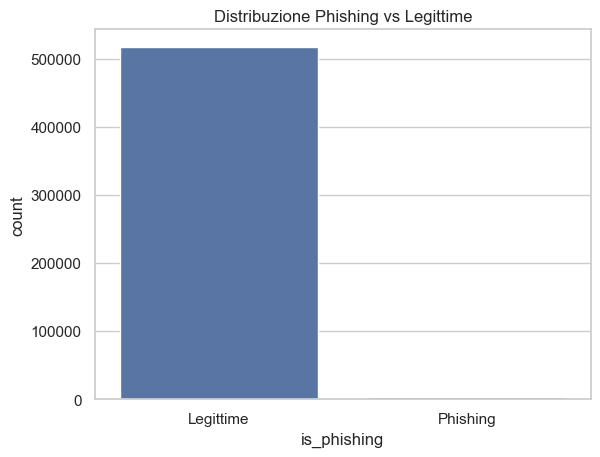

In [59]:
sns.countplot(data=df, x='is_phishing')
plt.title("Distribuzione Phishing vs Legittime")
plt.xticks([0,1], ['Legittime', 'Phishing'])
plt.show()


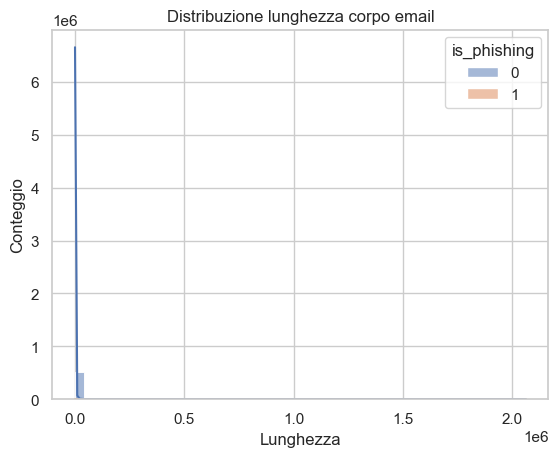

In [60]:
sns.histplot(data=df, x='body_length', hue='is_phishing', bins=50, kde=True)
plt.title("Distribuzione lunghezza corpo email")
plt.xlabel("Lunghezza")
plt.ylabel("Conteggio")
plt.show()


In [ ]:
df['num_attachments'] = df['filename_list'].apply(lambda x: len(eval(x)))

sns.boxplot(data=df, x='is_phishing', y='num_attachments')
plt.title("Numero allegati: Phishing vs Legittime")
plt.xticks([0,1], ['Legittime', 'Phishing'])
plt.show()


In [ ]:
if part.get_content_disposition() == "attachment":
    filename = part.get_filename()
    payload = part.get_payload(decode=True)
    if filename and payload:
        # Salva o analizza l'allegato come per Nazario


In [62]:
from email import policy
from email.parser import BytesParser

with open("email.eml", "rb") as f:
    msg = BytesParser(policy=policy.default).parse(f)

# Scorri tutte le parti del messaggio
for part in msg.walk():
    print("Content-Type:", part.get_content_type())
    print("Content-Disposition:", part.get_content_disposition())
    print("Filename:", part.get_filename())


FileNotFoundError: [Errno 2] No such file or directory: 'email.eml'

In [64]:
import os
import mailparser
from tqdm import tqdm

base_dir = "../dataset/nazario/eml_extracted"
total_emails = 0
emails_with_attachments = 0

for root, _, files in os.walk(base_dir):
    for file in tqdm(files, desc="Scanning Nazario emails"):
        if file.endswith((".eml", ".txt")):
            path = os.path.join(root, file)
            try:
                mail = mailparser.parse_from_file(path)
                total_emails += 1
                if mail.attachments and len(mail.attachments) > 0:
                    emails_with_attachments += 1
            except Exception as e:
                print(f"❌ Failed to parse {file}: {e}")

print(f"\nTotale email analizzate: {total_emails}")
print(f"Email con almeno un allegato: {emails_with_attachments}")


Scanning Nazario emails:   0%|          | 0/2984 [00:00<?, ?it/s]More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from kurniacahyagroup by server.akbar-it.co.id with local Exim 4.85 envelope-from <kurniacahyagroup@server.akbar-it.co.id> id 1Z1vjt-000600-Ia for jose@monkey.org; Mon, 08 Jun 2015 12:01:13 +0000
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from kurniacahyagroup by server.akbar-it.co.id with local Exim 4.85 envelope-from <kurniacahyagroup@server.akbar-it.co.id> id 1Z1vjt-000600-Ia for jose@monkey.org; Mon, 08 Jun 2015 12:01:13 +0000
More than one match found for [^\w](?:id\s+(?P<id>.+?)(?:\s*[(]?envelope-from|\s*[(]?envelope-sender|\s+from|\s+by|\s+with(?! cipher)|\s+for|\s+via|;)) in from nobody by coho3-2.cbncloud.co.id with local Exim 4.85 envelope-from <nobo


Totale email analizzate: 2984
Email con almeno un allegato: 511
